# Restaurant Industry Consulting Firm
July 17, 2019<br>
Ngoc, Mindy, Inferential Statistics<br>
one way anova, Welch anova, Tukey HSD for location in the DMV Area
Welch’s T-Tests and T-Tests for Cuisine, Price Range, and Hours of Operation in the DMV Area

-----------------

In this notebook, we want to:

- Find the best location (DC, MD, VA) to open a restaurant
- Find the 2 most popular cuisines in each DMV area
- Apply Welch’s t-tests and t-tests to figure out the more popular cuisine
- Apply Welch’s t-tests and t-tests to figure out the higher rating cuisine
- Apply Welch’s t-tests to figure out the better price range
- Apply Welch’s t-tests and t-tests to figure out the better hours of operation

-------------------

## Import Needed Libraries

In [1]:
import helper_functions as hf
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin    # welch F test
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings("ignore")

### Take a look at restaurant count for each location
  * DC appears to have the most number of restaurants 
  * MD appears to have the least number of restaurants 
  * All three tend to have around 2000 restaurants 

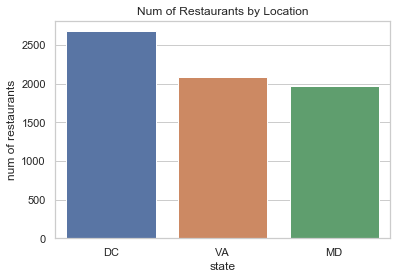

In [2]:
# import location and price df from datacleaning file
df_location_price = pd.read_pickle('data/yelp_price_location.pkl')
# obtain num_of_restaurant for each location
count_state = df_location_price.groupby('state').size(
).reset_index().rename(columns={0: 'num of restaurants'})
sns.barplot(x='state', y='num of restaurants', order=[
            'DC', 'VA', 'MD'], data=count_state)
plt.title('Num of Restaurants by Location')
plt.show()

## Split location_price dataframe into 3 groups:
  * DC, VA, MD

In [3]:
group_name = ['DC','MD','VA']
state_groups = hf.splitgroups(df_location_price, 'state', group_name)
DC = state_groups[0]
MD = state_groups[1]
VA = state_groups[2]

## Hypothesis 1:
  * restaurants tend to perform better in certain locations than others 
  * metrics:  
    * review_counts (proxy for customer traffic)
    * yelp review rating 
  * Null Hypothesis: there are no differences among the 3 locations 
  * method: one way anova 
    * check for anova assumption:  
        * Normality:  
          * Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality  
        * Homogeneity of variance  
          * Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation  
        * Independent observations (assume independent most of the time)

### Normality test 

In [4]:
# create a statistictestclass 
statisticaltests = hf.InferentialStatisticsHelperFunctions()
# check for normality 
metrics = ['review_count','rating']
statisticaltests.normality_tests(state_groups, group_name, metrics)

,DC,MD,VA
rating,not normal,not normal,not normal
review_count,not normal,not normal,not normal


### Distribution is not normal, we will use central limit theorem to produce a normal distribution by performing boostrap sampling 

In [5]:
# boostrap generate sample means from 100 samples for 100000 times (CLT)
DC_review = statisticaltests.sample_category(DC,100,100000,'review_count')
MD_review = statisticaltests.sample_category(MD,100,100000,'review_count')
VA_review = statisticaltests.sample_category(VA,100,100000,'review_count')
DC_rating = statisticaltests.sample_category(DC,100,100000,'rating')
MD_rating = statisticaltests.sample_category(MD,100,100000,'rating')
VA_rating = statisticaltests.sample_category(VA,100,100000,'rating')

### Variance equal test 

In [6]:
group_review = [DC_review, MD_review, VA_review]
# create proper table format to perform equal variance test
stacked_df_review = hf.table_transform(
    group_review, group_name, colname='review_count')
print('review_count:', statisticaltests.variance_tests(group_review))
group_rating = [DC_rating, MD_rating, VA_rating]
# create proper table format to perform equal variance test
stacked_df_rating = hf.table_transform(
    group_rating, group_name, colname='rating')
print('rating:', statisticaltests.variance_tests(group_rating))

review_count: not equal variance 
rating: not equal variance 


### Due to equal sample size, we will perform both oneway anova and welch F test to compare results 

In [7]:
# one way anova
print('review_count:', statisticaltests.one_way_anova(group_review))
print('rating:', statisticaltests.one_way_anova(group_rating))

review_count: reject Null Hypothesis
rating: reject Null Hypothesis


In [8]:
# welch F test (doesn't assume equal variance)
print('review_count:', statisticaltests.welch_f_test(
    stacked_df_review, 'review_count', 'state'))
print('rating:', statisticaltests.welch_f_test(
    stacked_df_rating, 'rating', 'state'))

review_count: reject Null Hypothesis
rating: reject Null Hypothesis


## Both reject Null Hypothesis of no difference  
 * However we don't know where the difference happens
 * it can be DC different from MD but MD and VA are the same
 * perform post ANOVA analysis to figure out the details of differences 
 * we will use tukey HSD test 

In [9]:
print('review_count:\n\n', statisticaltests.tukey_hsd(stacked_df_review,'review_count'))
print('rating:\n\n',statisticaltests.tukey_hsd(stacked_df_rating, 'rating'))

review_count:

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
    DC     MD -113.1641 0.001 -113.4855 -112.8428   True
    DC     VA  -38.9312 0.001  -39.2526  -38.6099   True
    MD     VA   74.2329 0.001   73.9115   74.5543   True
--------------------------------------------------------
rating:

 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    DC     MD  -0.2898 0.001 -0.2906 -0.2889   True
    DC     VA  -0.0615 0.001 -0.0624 -0.0607   True
    MD     VA   0.2282 0.001  0.2273  0.2291   True
---------------------------------------------------


## Results:
  * the mean diff for null hypothesis is zero 
  * the calculated 95% confidence interval is outside zero difference 
  * we will conclude as following:
    * for both rating and review counts 
      * DC has lower rating and less review counts than MD 
      * DC has lower rating and less review counts than VA
      * MD has higher rating and higher review counts than VA
    

### Hypothesis 2: 
-----------------------
## - cuisine

#### Load Needed Data

In [3]:
dc = pd.read_csv("data/dc_restaurants_cuisine.csv")
va = pd.read_csv("data/va_restaurants_cuisine.csv")
md = pd.read_csv("data/md_restaurants_cuisine.csv")

## Inferential Statistics

Use $\alpha = 0.05$ throughout this notebook.

Get helper functions:

In [ ]:
hf = helper_functions.InferentialStatisticsHelperFunctions()

### DC
**Find the 2 most popular cuisines:**

What are the 2 most popular cuisines in DC, based on the "standardized" number of reviews? Note: We use review_count to imply popularity.

In [ ]:
hf.top_two_cuisines(dc, "review_count")

----------------------
Our candidates are Ramen and Spanish. We want to know if there are statistical differences between these two.<br><br>
H0: $\mu_{Ramen} = \mu_{Spanish}$<br>
H1: $\mu_{Ramen} \neq \mu_{Spanish}$

---------------------------

## Based upon cuisine study, we found the following: 
  * Bars have the highest normalized review count in VA and MD 
  * Bars have the highest normalized rating in MD 
  * Ramen has the highest normalized review count and normalized rating in DC 
  
  The first cuisine:

In [ ]:
dc_first_review_count, dc_first_rating = hf.get_cuisine(dc, "Ramen")

The second cuisine:

In [ ]:
dc_second_review_count, dc_second_rating = hf.get_cuisine(dc, "Spanish")

**Check if the distributions of the two groups follow the normal distribution:**

H0: the data was drawn from a normal distribution<br>
H1: the data was not drawn from a normal distribution

*review_count*

In [ ]:
stats.shapiro(dc_first_review_count)

In [ ]:
stats.shapiro(dc_second_review_count)

*rating*

In [ ]:
stats.shapiro(dc_first_rating)

In [ ]:
stats.shapiro(dc_second_rating)

Rejecting the null hypotheses leads to normality assumption being violated.

**Have to bootstrap:**

In [ ]:
np.random.seed(546435)
dc_first_review_count_bs = hf.sampling(dc_first_review_count, 100000, 1000)
dc_second_review_count_bs = hf.sampling(dc_second_review_count, 100000, 1000)
dc_first_rating_bs = hf.sampling(dc_first_rating, 100000, 1000)
dc_second_rating_bs = hf.sampling(dc_second_rating, 100000, 1000)

**Check for normality again:**

*review_count*

In [ ]:
stats.shapiro(dc_first_review_count_bs)

In [ ]:
stats.shapiro(dc_second_review_count_bs)

*rating*

Fail to reject the null hypotheses. Good!

**Check if the two groups are from populations with equal variances:**

*review_count*

In [16]:
stats.levene(dc_first_review_count_bs, dc_second_review_count_bs)

LeveneResult(statistic=13.93471430305082, pvalue=0.0001945633357491114)

Rejecting the null hypothesis leads to variance assumption being violated.

*rating*

In [17]:
stats.levene(dc_first_rating_bs, dc_second_rating_bs)

LeveneResult(statistic=1.989322751018498, pvalue=0.15856737164793835)

Fail to reject the null hypothesis. Good!

**Desired Inferential Statistics:**

Welch’s t-test:<br>
We want: Ramen's popularity is not the same as Spanish's popularity.

In [18]:
stats.ttest_ind(dc_first_review_count_bs, dc_second_review_count_bs, equal_var=False)

Ttest_indResult(statistic=597.529963772672, pvalue=0.0)

Reject the null hypothesis. t-statistic is positive.<br>
Ramen wins!

t-test:<br>
We want: Ramen's rating is not the same as Spanish's rating.

In [19]:
stats.ttest_ind(dc_first_rating_bs, dc_second_rating_bs)

Ttest_indResult(statistic=807.1305078288788, pvalue=0.0)

Reject the null hypothesis. t-statistic is positive.<br>
Ramen wins!

**Plot the Two Groups:**

*review_count*

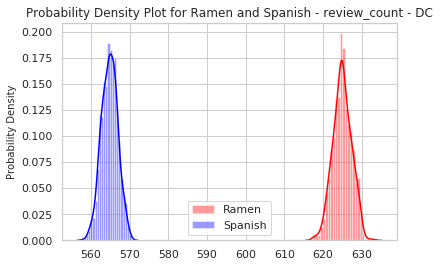

In [20]:
hf.plot_distribution(dc_first_review_count_bs, dc_second_review_count_bs, ["Ramen", "Spanish"], "review_count - DC")

*rating*

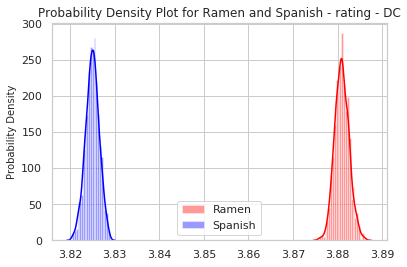

In [21]:
hf.plot_distribution(dc_first_rating_bs, dc_second_rating_bs, ["Ramen", "Spanish"], "rating - DC")

**Conclusion:** We'd want to open a Ramen restaurant in DC.

### VA

**Find the 2 most popular cuisines:**

What are the 2 most popular cuisines in VA, based on the "standardized" number of reviews? Note: We use review_count to imply popularity.

In [22]:
hf.top_two_cuisines(va, "review_count")

Index(['Bars', 'Seafood'], dtype='object', name='cuisine')


----------------------
Our candidates are Bars and Seafood. We want to know if there are statistical differences between these two.<br><br>
H0: $\mu_{Bars} = \mu_{Seafood}$<br>
H1: $\mu_{Bars} \neq \mu_{Seafood}$

---------------------------

The first cuisine:

In [23]:
va_first_review_count, va_first_rating = hf.get_cuisine(va, "Bars")

The second cuisine:

In [24]:
va_second_review_count, va_second_rating = hf.get_cuisine(va, "Seafood")

**Check if the distributions of the two groups follow the normal distribution:**

H0: the data was drawn from a normal distribution<br>
H1: the data was not drawn from a normal distribution

*review_count*

In [25]:
stats.shapiro(va_first_review_count)

(0.8068469166755676, 1.0536710393083126e-10)

In [26]:
stats.shapiro(va_second_review_count)

(0.8101442456245422, 3.754873745265286e-09)

*rating*

In [27]:
stats.shapiro(va_first_rating)

(0.9266953468322754, 1.3774934814136941e-05)

In [28]:
stats.shapiro(va_second_rating)

(0.8725098371505737, 4.7185949370032176e-07)

Rejecting the null hypotheses leads to normality assumption being violated.

**Have to bootstrap:**

In [29]:
np.random.seed(314874)
va_first_review_count_bs = hf.sampling(va_first_review_count, 100000, 1000)
va_second_review_count_bs = hf.sampling(va_second_review_count, 100000, 1000)
va_first_rating_bs = hf.sampling(va_first_rating, 100000, 1000)
va_second_rating_bs = hf.sampling(va_second_rating, 100000, 1000)

**Check for normality again:**

*review_count*

In [30]:
stats.shapiro(va_first_review_count_bs)

(0.998667299747467, 0.6664901971817017)

In [31]:
stats.shapiro(va_second_review_count_bs)

(0.998412013053894, 0.49850475788116455)

*rating*

In [32]:
stats.shapiro(va_first_rating_bs)

(0.9991390705108643, 0.9347654581069946)

In [33]:
stats.shapiro(va_second_rating_bs)

(0.999219536781311, 0.960389256477356)

Fail to reject the null hypotheses. Good!

**Check if the two groups are from populations with equal variances:**

*review_count*

In [34]:
stats.levene(va_first_review_count_bs, va_second_review_count_bs)

LeveneResult(statistic=0.14040278431161762, pvalue=0.7079206841429102)

*rating*

In [35]:
stats.levene(va_first_rating_bs, va_second_rating_bs)

LeveneResult(statistic=0.3347071435428664, pvalue=0.5629656153001051)

Fail to reject the null hypotheses. Good!

**Desired Inferential Statistics:**

t-test:<br>
We want: Bars' popularity is not the same as Seafood's popularity.

In [36]:
stats.ttest_ind(va_first_review_count_bs, va_second_review_count_bs)

Ttest_indResult(statistic=757.4645546550039, pvalue=0.0)

Reject the null hypothesis. t-statistic is positive.<br>
Bars wins!

t-test:<br>
We want: Bars' rating is not the same as Seafood's rating.

In [37]:
stats.ttest_ind(va_first_rating_bs, va_second_rating_bs)

Ttest_indResult(statistic=-774.3715293190149, pvalue=0.0)

Reject the null hypothesis. t-statistic is negative.<br>
Seafood wins!

**Plot the Two Groups:**

*review_count*

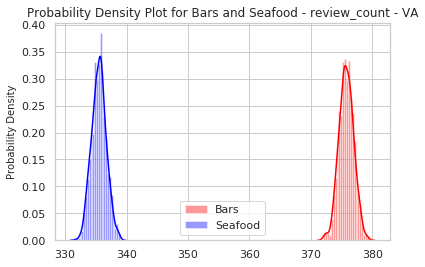

In [38]:
hf.plot_distribution(va_first_review_count_bs, va_second_review_count_bs, ["Bars", "Seafood"], "review_count - VA")

**Conclusion:** Bars have more traffic but rating favors Seafood restaurants.

*rating*

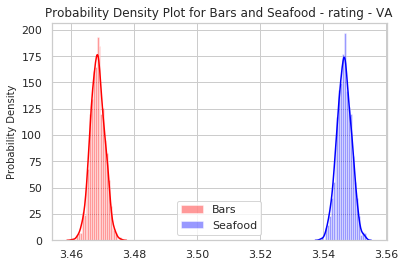

In [39]:
hf.plot_distribution(va_first_rating_bs, va_second_rating_bs, ["Bars", "Seafood"], "rating - VA")

### MD

**Find the 2 most popular cuisines:**

What are the 2 most popular cuisines in MD, based on the "standardized" number of reviews? Note: We use review_count to imply popularity.

In [40]:
hf.top_two_cuisines(md, "review_count")

Index(['Bars', 'American (New)'], dtype='object', name='cuisine')


----------------------
Our candidates are Bars and American (New). We want to know if there are statistical differences between these two.<br><br>
H0: $\mu_{Bars} = \mu_{American (New)}$<br>
H1: $\mu_{Bars} \neq \mu_{American (New)}$

---------------------------

The first cuisine:

In [41]:
md_first_review_count, md_first_rating = hf.get_cuisine(md, "Bars")

The second cuisine:

In [42]:
md_second_review_count, md_second_rating = hf.get_cuisine(md, "American (New)")

**Check if the distributions of the two groups follow the normal distribution:**

H0: the data was drawn from a normal distribution<br>
H1: the data was not drawn from a normal distribution

*review_count*

In [43]:
stats.shapiro(md_first_review_count)

(0.6900336742401123, 1.3818322042169484e-09)

In [44]:
stats.shapiro(md_second_review_count)

(0.6912879943847656, 1.3027578148194774e-12)

*rating*

In [45]:
stats.shapiro(md_first_rating)

(0.9410432577133179, 0.008609042502939701)

In [46]:
stats.shapiro(md_second_rating)

(0.9171949028968811, 2.141371078323573e-05)

Rejecting the null hypotheses leads to normality assumption being violated.

**Have to bootstrap:**

In [47]:
np.random.seed(35457)
md_first_review_count_bs = hf.sampling(md_first_review_count, 100000, 1000)
md_second_review_count_bs = hf.sampling(md_second_review_count, 100000, 1000)
md_first_rating_bs = hf.sampling(md_first_rating, 100000, 1000)
md_second_rating_bs = hf.sampling(md_second_rating, 100000, 1000)

**Check for normality again:**

*review_count*

In [48]:
stats.shapiro(md_first_review_count_bs)

(0.9992197751998901, 0.9604592323303223)

In [49]:
stats.shapiro(md_second_review_count_bs)

(0.9986486434936523, 0.6538873314857483)

*rating*

In [50]:
stats.shapiro(md_first_rating_bs)

(0.9986286759376526, 0.6403818726539612)

In [51]:
stats.shapiro(md_second_rating_bs)

(0.9983735680580139, 0.4748717248439789)

Fail to reject the null hypotheses. Good!

**Check if the two groups are from populations with equal variances:**

*review_count*

In [52]:
stats.levene(md_first_review_count_bs, md_second_review_count_bs)

LeveneResult(statistic=3.1097143410194996, pvalue=0.07797943583985648)

Fail to reject the null hypothesis. Good!

*rating*

In [53]:
stats.levene(md_first_rating_bs, md_second_rating_bs)

LeveneResult(statistic=12.365938167164519, pvalue=0.0004469930215481184)

Rejecting the null hypothesis leads to variance assumption being violated.

**Desired Inferential Statistics:**

t-test:<br>
We want: Bars' popularity is not the same as American (New)'s popularity.

In [54]:
stats.ttest_ind(md_first_review_count_bs, md_second_review_count_bs)

Ttest_indResult(statistic=1011.6349050663866, pvalue=0.0)

Reject the null hypothesis. t-statistic is positive.<br>
Bars wins!

Welch’s t-test:<br>
We want: Bars' rating is not the same as American (New)'s rating.

In [55]:
stats.ttest_ind(md_first_rating_bs, md_second_rating_bs, equal_var=False)

Ttest_indResult(statistic=853.6946379107173, pvalue=0.0)

Reject the null hypothesis. t-statistic is positive.<br>
Bars wins!

**Plot the Two Groups:**

*review_count*

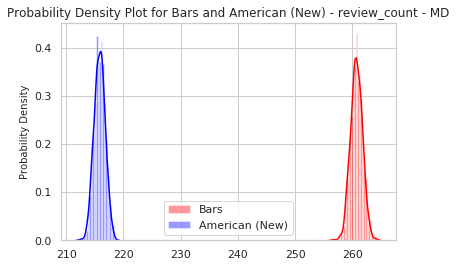

In [56]:
hf.plot_distribution(md_first_review_count_bs, md_second_review_count_bs, ["Bars", "American (New)"], "review_count - MD")

*rating*

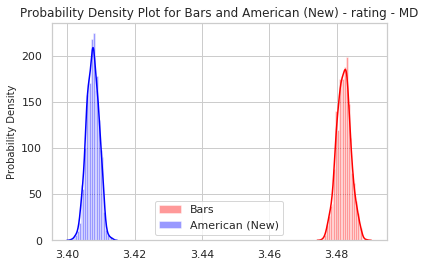

In [57]:
hf.plot_distribution(md_first_rating_bs, md_second_rating_bs, ["Bars", "American (New)"], "rating - MD")

**Conclusion:** We'd want to open a bar in MD.

**Conclusion:** Bars have more traffic but rating favors Seafood restaurants.

## After hypothesis I and II:
### We will first filter out ramen and bars and look at if there are any correlation between location and ramen vs bars 

In [10]:
# split category combo into separate rows
table = hf.split_rows(df_location_price,'Lat', 'categories', '|')
table = table.rename(columns = {'index': 'category', 0: 'Lat'})
# join table 
mergedtable = pd.merge(df_location_price,table, on = 'Lat')
# filter out only bars and ramen 
filtered_df = mergedtable[(mergedtable.category=='Bars')|(mergedtable.category =='Ramen')]
statisticaltests.chisquare_test(filtered_df, 'state','category')

'fail to reject Null Hypothesis'

### Chisquare independence test result:
  * Null Hypothesis says no correlation between category and state 
  * alternative hypthesis says there are some influence between state and category of food 
  * we fail to reject null hypothesis so we conclude no correlation between location and ramen or bars

## Hypothesis 3:
  * prices:\\$ to \\$\\$ and \\$\\$\\$ to \\$\\$\\$\\$
  * metrics:  
    * review_counts (proxy for customer traffic)
    * yelp review rating 
  * Null Hypothesis: there are no differences between \\$ to \\$\\$ and \\$\\$\\$ to \\$\\$\\$\\$
  * method: welch's T test 
    * check for welch's T test assumption:  
        * Normality

### First we will look at how price works across all locations and restaurants 
  * we replaced the null price values with 3 methods:
    * median price 
    * random value with proportions of the price distribution 
    * remove null price 
  * compare results 

In [11]:
# import location and price df for random, remove na,and median from datacleaning 
# use median to replace null price values
df_median = pd.read_pickle('data/median_price.pkl')  
# use np random to replace null price values
df_random = pd.read_pickle('data/random_price.pkl')  
# remove null price values 
df_na = pd.read_pickle('data/na_remove.pkl')

In [12]:
# generate 3 groups of DC, VA, MD for all three price df 
median_df = hf.splitgroups(df_median, 'state', group_name)
na_df = hf.splitgroups(df_na, 'state',group_name)
random_df = hf.splitgroups(df_random, 'state',group_name)

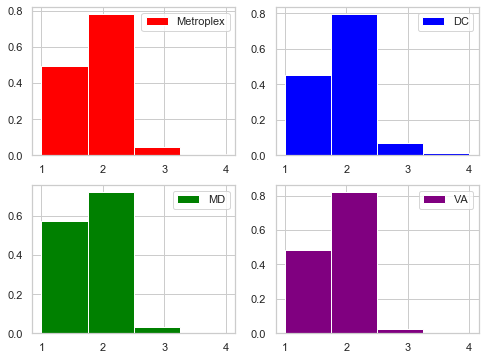

In [13]:
# check for price distribution visualization comparsion 
hf.plothist(df_median,median_df) 

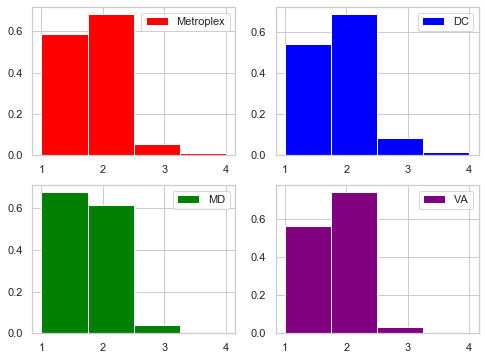

In [14]:
hf.plothist(df_na, na_df)
# similar distribution across all 

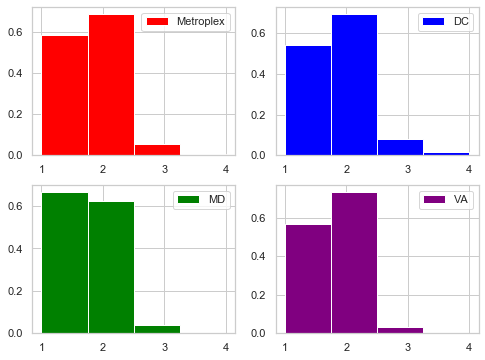

In [15]:
hf.plothist(df_random,random_df)
# distributions the same all across 

### All three NA price method seem to produce similar price range distribution 

### We will split price into 2 groups of above \\$\\$ and below \\$\\$
  * perform welch T test 
    * first check normality 

In [16]:
print('median_df:\n\n', statisticaltests.normality_tests(
    median_df, group_name, ['review_count', 'rating']))
print('na_df:\n\n', statisticaltests.normality_tests(
    na_df, group_name, ['review_count', 'rating']))
print('random_df:\n\n', statisticaltests.normality_tests(
    random_df, group_name, ['review_count', 'rating']))

median_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal
na_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal
random_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal


### None are normally distributed 
#### Use central limit thereom and perform bootstrap sampling 
  * first split each data into high low price range for comparison 
  * bootstrap for each group 
  * perform welch T test (assume unequal variance)

In [17]:
names = ['$$$-$$$$','$-$$']
print ('df_median review_count:')
print(statisticaltests.price_welcht(df_median,'price',2,'review_count',100,100000,names))
print ('df_na review_count:')
print(statisticaltests.price_welcht(df_na,'price',2,'review_count',100,100000,names))
print ('df_random review_count:')
print(statisticaltests.price_welcht(df_random,'price',2,'review_count',100,100000,names))

df_median review_count:
$$$-$$$$ appears to statistically perform better than $-$$
df_na review_count:
$$$-$$$$ appears to statistically perform better than $-$$
df_random review_count:
$$$-$$$$ appears to statistically perform better than $-$$


In [18]:
names = ['$$$-$$$$','$-$$']
print ('df_median rating:')
print(statisticaltests.price_welcht(df_median,'price',2,'rating',100,100000,names))
print ('df_na rating:')
print(statisticaltests.price_welcht(df_na,'price',2,'rating',100,100000,names))
print ('df_random rating:')
print(statisticaltests.price_welcht(df_random,'price',2,'rating',100,100000,names))

df_median rating:
$$$-$$$$ appears to statistically perform better than $-$$
df_na rating:
$$$-$$$$ appears to statistically perform better than $-$$
df_random rating:
$$$-$$$$ appears to statistically perform better than $-$$


### Let's focus on MD and focus on bars 

In [23]:
# look at maryland and bar only 
mask = (mergedtable.category == 'Bars') & (mergedtable.state =='MD')
MD_bars = mergedtable[mask]
# fill the value with np.random 
np.random.seed(42)
proportions = MD_bars.price.value_counts(normalize=True)
rows = []
for i, row in MD_bars[MD_bars.price.isnull()].iterrows():
    rows.append(np.random.choice(
        a=proportions.index, replace=True, p=proportions))
MD_bars.price[MD_bars.price.isnull()] = rows
MD_bars.price = MD_bars.price.astype('int')

In [27]:
np.random.seed(100)
print('review_count welch t test:')
print(statisticaltests.price_welcht(MD_bars, 'price', 2,
                                    'review_count', 50, 100000, ['$$$-$$$$', '$-$$']))
print('rating welch t test')
print(statisticaltests.price_welcht(MD_bars, 'price',
                                    2, 'rating', 50, 100000, ['$$$-$$$$', '$-$$']))

review_count welch t test:
$$$-$$$$ appears to statistically perform better than $-$$
rating welch t test
$$$-$$$$ appears to statistically perform better than $-$$


### Welch T test result for price tag:
  * all category of foods and all 3 locations:
    * all 3 price na fill value provide the same result:
      * reject Null Hypothesis 
      * higher than \\$\\$ performs better in both rating and review_count  
  * looking at MD and Bar (using np.random with proportion to fill):  
      * reject Null Hypothesis 
      * higher than \\$\\$ performs better in both rating and review_count

### Visualization of the MD_bar high low price rating and review count distribution
  * bootstrap sampling from original samples. 

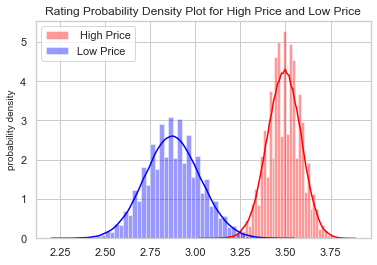

In [25]:
np.random.seed(20)
price_splits_rt = hf.samples(MD_bars, 'price', 2, 'rating')
price_high_rt = statisticaltests.sampling(price_splits_rt[0],50,100000)
price_low_rt = statisticaltests.sampling(price_splits_rt[1],50,100000)
statisticaltests.plot_distribution(price_high_rt,price_low_rt, [' High Price','Low Price'],featurename='Rating')

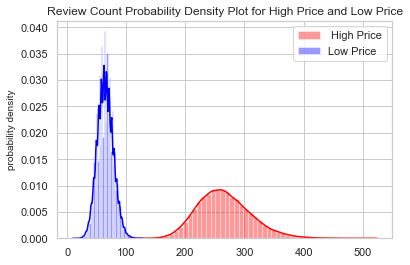

In [26]:
np.random.seed(18)
price_splits_re = hf.samples(MD_bars, 'price', 2, 'review_count')
price_high_re = statisticaltests.sampling(price_splits_re[0],50,100000)
price_low_re = statisticaltests.sampling(price_splits_re[1],50,100000)
statisticaltests.plot_distribution(price_high_re,price_low_re, [' High Price','Low Price'],'Review Count')

---------------------------------
## - open_pass_midnight
We have decided to run a bar in MD. Should we open pass midnight or should we close early?

**Create 2 data sets:**

- bars in MD, open pass midnight
- bars in MD, closed before midnight

In [58]:
pass_midnight_review_count, pass_midnight_rating, not_pass_midnight_review_count, not_pass_midnight_rating = hf.get_bars_open_info(md)

**Check if the distributions of the two groups follow the normal distribution:**

H0: the data was drawn from a normal distribution<br>
H1: the data was not drawn from a normal distribution

*review_count*

In [59]:
stats.shapiro(pass_midnight_review_count)

(0.8629341125488281, 0.007154344115406275)

In [60]:
stats.shapiro(not_pass_midnight_review_count)

(0.6778969764709473, 1.7195308998907421e-07)

*rating*

In [61]:
stats.shapiro(pass_midnight_rating)

(0.9260075688362122, 0.11447566747665405)

In [62]:
stats.shapiro(not_pass_midnight_rating)

(0.8766323328018188, 0.0009863132145255804)

**Bootstrap:**

In [63]:
np.random.seed(45984531)
pass_midnight_review_count_bs = hf.sampling(pass_midnight_review_count, 100000, 1000)
not_pass_midnight_review_count_bs = hf.sampling(not_pass_midnight_review_count, 100000, 1000)
pass_midnight_rating_bs = hf.sampling(pass_midnight_rating, 100000, 1000)
not_pass_midnight_rating_bs = hf.sampling(not_pass_midnight_rating, 100000, 1000)

**Check for normality again:**

*review_count*

In [64]:
stats.shapiro(pass_midnight_review_count_bs)

(0.9987057447433472, 0.6924406290054321)

In [65]:
stats.shapiro(not_pass_midnight_review_count_bs)

(0.9987625479698181, 0.7303594946861267)

*rating*

In [66]:
stats.shapiro(pass_midnight_rating_bs)

(0.998740553855896, 0.715727686882019)

In [67]:
stats.shapiro(not_pass_midnight_rating_bs)

(0.9971408843994141, 0.07214023172855377)

Fail to reject the null hypotheses. Good!

**Check if the two groups are from populations with equal variances:**

*review_count*

In [68]:
stats.levene(pass_midnight_review_count_bs, not_pass_midnight_review_count_bs)

LeveneResult(statistic=289.8198016346828, pvalue=8.535837781318509e-61)

*rating*

In [69]:
stats.levene(pass_midnight_rating_bs, not_pass_midnight_rating_bs)

LeveneResult(statistic=60.093135959589276, pvalue=1.4298654424913025e-14)

Rejecting the null hypothesis leads to variance assumption being violated.

**Desired Inferential Statistics:**

Welch’s t-test:<br>
We want: pass_midnight's review_count is not the same as not_pass_midnight's review_count.

In [70]:
stats.ttest_ind(pass_midnight_review_count_bs, not_pass_midnight_review_count_bs, equal_var=False)

Ttest_indResult(statistic=-2383.4886945376957, pvalue=0.0)

Reject the null hypothesis. t-statistic is negative.<br>
not_pass_midnight wins!

Welch’s t-test:<br>
We want: pass_midnight's rating is not the same as not_pass_midnight's rating.

In [71]:
stats.ttest_ind(pass_midnight_rating_bs, not_pass_midnight_rating_bs, equal_var=False)

Ttest_indResult(statistic=-4237.331040257049, pvalue=0.0)

Reject the null hypothesis. t-statistic is negative.<br>
not_pass_midnight wins!

**Plot the Two Groups:**

*review_count*

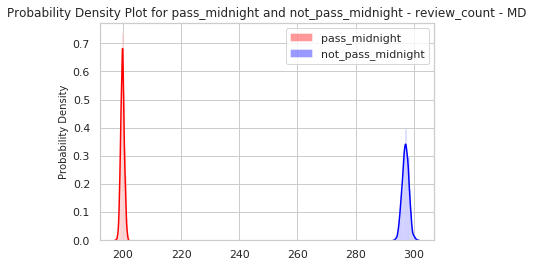

In [72]:
hf.plot_distribution(pass_midnight_review_count_bs, not_pass_midnight_review_count_bs, ["pass_midnight", "not_pass_midnight"], "review_count - MD")

*rating*

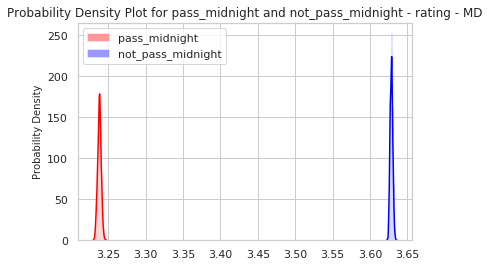

In [73]:
hf.plot_distribution(pass_midnight_rating_bs, not_pass_midnight_rating_bs, ["pass_midnight", "not_pass_midnight"], "rating - MD")

**Conclusion:** We'd want to close our bar in MD before midnight.

* Sources:  

  * https://www.yelp.com/developers/documentation/v3/business
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
  * https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
  * https://pingouin-stats.org/generated/pingouin.welch_anova.html#pingouin.welch_anova
  * https://docs.scipy.org/doc/scipy/reference/stats.html
  * https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html
